In [1]:
import os

glob_path = '/opt/iui-datarelease2-sose2021/*/split_letters_csv/*'

pickle_file = 'data.pickle'

create_new = False
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# divisor for neuron count step downs (hard to describe), e.g. dense_step = 3: layer1=900, layer2 = 300, layer3 = 100, layer4 = 33...
dense_steps = 2
# amount of dense/dropout layers
layer_count = 3
# how much to drop
drop_count = 0.1

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # this is required
os.environ['CUDA_VISIBLE_DEVICES'] = '2'         # set to '0' for GPU0, '1' for GPU1 or '2' for GPU2. Check "gpustat" in a terminal.

In [3]:
from glob import glob
import pandas as pd
from tqdm import tqdm

def dl_from_blob(filename) -> list:
    all_data = []
    
    for path in tqdm(glob(filename)):
        path = path
        df = pd.read_csv(path, ';')
        u = path.split('/')[3]
        l = ''.join(filter(lambda x: x.isalpha(), path.split('/')[5]))[0] 
        d = {
            'file': path,
            'data': df,
            'user': u,
            'label': l
        }
        all_data.append(d)
    return all_data

In [4]:
def save_pickle(f, structure):
    _p = open(f, 'wb')
    pickle.dump(structure, _p)
    _p.close()

In [5]:
import pickle

def load_pickles(f) -> list:
    _p = open(pickle_file, 'rb')
    _d = pickle.load(_p)
    _p.close()
    
    return _d

In [6]:
import os
def load_data() -> list:
    if os.path.isfile(pickle_file):
        print(f'{pickle_file} found...')
        return load_pickles(pickle_file)
    print(f'Didn\'t find {pickle_file}...')
    all_data = dl_from_blob(glob_path)
    print(f'Creating {pickle_file}...')
    save_pickle(pickle_file, all_data)
    return all_data

print("Loading data...")
data = load_data()
# plot_pd(data[0]['data'], False)

Loading data...
data.pickle found...


In [7]:
import matplotlib.pyplot as plt

def plot_pd(data, force=True):
    fig, axs = plt.subplots(5, 3, figsize=(3*3, 3*5))
    axs[0][0].plot(data['Acc1 X'])
    axs[0][1].plot(data['Acc1 Y'])
    axs[0][2].plot(data['Acc1 Z'])
    axs[1][0].plot(data['Acc2 X'])
    axs[1][1].plot(data['Acc2 Y'])
    axs[1][2].plot(data['Acc2 Z'])
    axs[2][0].plot(data['Gyro X'])
    axs[2][1].plot(data['Gyro Y'])
    axs[2][2].plot(data['Gyro Z'])
    axs[3][0].plot(data['Mag X'])
    axs[3][1].plot(data['Mag Y'])
    axs[3][2].plot(data['Mag Z'])
    axs[4][0].plot(data['Time'])

    if force:
        for a in axs:
            for b in a:
                b.plot(data['Force'])
    else:
        axs[4][1].plot(data['Force'])

def plot_np(data, force=True):
    fig, axs = plt.subplots(5, 3, figsize=(3*3, 3*5))
    axs[0][0].plot(data[0])
    axs[0][1].plot(data[1])
    axs[0][2].plot(data[2])
    axs[1][0].plot(data[3])
    axs[1][1].plot(data[4])
    axs[1][2].plot(data[5])
    axs[2][0].plot(data[6])
    axs[2][1].plot(data[7])
    axs[2][2].plot(data[8])
    axs[3][0].plot(data[9])
    axs[3][1].plot(data[10])
    axs[3][2].plot(data[11])
    axs[4][0].plot(data[13])

    if force:
        for a in axs:
            for b in a:
                b.plot(data[12])
    else:
        axs[4][1].plot(data[12])


In [8]:
def mill_drop(entry):
    #drop millis on single
    data_wo_mill = entry['data'].drop(labels='Millis', axis=1, inplace=False)
    drop_entry = entry
    drop_entry['data'] = data_wo_mill.reset_index(drop=True)
    
    return drop_entry

In [9]:
import numpy as np

def cut_force(drop_entry):
    # force trans
    shorten_entry = drop_entry
    shorten_data = shorten_entry['data']
    sf_entry = shorten_data['Force']
    leeway = 10
    
    try:
        thresh = 70
        temps_over_T = np.where(sf_entry > thresh)[0]
        shorten_data = shorten_data[max(temps_over_T.min()-leeway,0):min(len(sf_entry)-1,temps_over_T.max()+leeway)]
    except:
        thresold = 0.05
        thresh = sf_entry.max()*thresold
        temps_over_T = np.where(sf_entry > thresh)[0]
        shorten_data = shorten_data[max(temps_over_T.min()-leeway,0):min(len(sf_entry)-1,temps_over_T.max()+leeway)]
    
    shorten_entry['data'] = shorten_data.reset_index(drop=True)
    return shorten_entry

In [10]:
def norm_force(shorten_entry, flist):
    fnorm_entry = shorten_entry
    u = fnorm_entry['user']
    d = fnorm_entry['data']
    
    
    d['Force'] = ((d['Force'] - flist[u].mean())/flist[u].std())
    
    fnorm_entry['data'] = fnorm_entry['data'].reset_index(drop=True)
    return fnorm_entry

In [11]:
def time_trans(fnorm_entry):
    #timetrans
    time_entry = fnorm_entry
    
    time_entry['data']['Time'] = fnorm_entry['data']['Time']-fnorm_entry['data']['Time'][0]
    
    time_entry['data'] = time_entry['data'].reset_index(drop=True)

    return time_entry

In [12]:
def norm(time_entry):
    # normalize
    norm_entry = time_entry
    
    norm_entry['data']['Acc1 X'] = norm_entry['data']['Acc1 X'] / 32768
    norm_entry['data']['Acc1 Y'] = norm_entry['data']['Acc1 Y'] / 32768
    norm_entry['data']['Acc1 Z'] = norm_entry['data']['Acc1 Z'] / 32768
    norm_entry['data']['Acc2 X'] = norm_entry['data']['Acc2 X'] / 8192
    norm_entry['data']['Acc2 Y'] = norm_entry['data']['Acc2 Y'] / 8192
    norm_entry['data']['Acc2 Z'] = norm_entry['data']['Acc2 Z'] / 8192
    norm_entry['data']['Gyro X'] = norm_entry['data']['Gyro X'] / 32768
    norm_entry['data']['Gyro Y'] = norm_entry['data']['Gyro Y'] / 32768
    norm_entry['data']['Gyro Z'] = norm_entry['data']['Gyro Z'] / 32768
    norm_entry['data']['Mag X']  = norm_entry['data']['Mag X']  / 8192
    norm_entry['data']['Mag Y']  = norm_entry['data']['Mag Y']  / 8192
    norm_entry['data']['Mag Z']  = norm_entry['data']['Mag Z']  / 8192
    
    norm_entry['data'] = norm_entry['data'].reset_index(drop=True)
    
    return norm_entry

In [13]:
def preproc(d):
    flist = {}  
    d_res = []
    for e in data:
        if e['user'] not in flist:
            flist[e['user']] = e['data']['Force']
        else:
            flist[e['user']] = flist[e['user']].append(e['data']['Force'])
    
    for e in tqdm(data):
        d_res.append(preproc_entry(e, flist))
    return d_res
    
def preproc_entry(entry, flist):
    drop_entry = mill_drop(entry)
#     plot_pd(drop_entry['data'])
#     
    shorten_entry = cut_force(drop_entry)
#     plot_pd(shorten_entry['data'])
#     
    fnorm_entry = norm_force(shorten_entry, flist)
#     plot_pd(fnorm_entry['data'])
#     
    time_entry = time_trans(shorten_entry)
#     plot_pd(time_entry['data'])
#     
    norm_entry = norm(time_entry)
#     plot_pd(norm_entry['data'], False)
    return norm_entry

print("Preprocessing...")
pdata = preproc(data)
# plot_pd(pdata[0]['data'], False)

Preprocessing...


100%|██████████| 26179/26179 [01:28<00:00, 294.18it/s]


In [14]:
def throw(pdata):
    llist = pd.Series([len(x['data']) for x in pdata])
    threshold = int(llist.quantile(threshold_p))
    longdex = np.where(llist <= threshold)[0]
    return np.array(pdata)[longdex]

llist = pd.Series([len(x['data']) for x in pdata])
threshold_p = 0.75
threshold = int(llist.quantile(threshold_p))

print("Truncating...")
tpdata = throw(pdata)
# plot_pd(tpdata[0]['data'], False)

Truncating...


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# ltpdata = []
def elong(tpdata):
    for x in tqdm(tpdata):
        y = x['data'].to_numpy().T
        x['data'] = pad_sequences(y, dtype=float, padding='post', maxlen=threshold)
    return tpdata

print("Padding...")
ltpdata = elong(tpdata)
# plot_np(ltpdata[0]['data'], False)

 18%|█▊        | 3624/19640 [00:00<00:00, 18199.99it/s]

Padding...


100%|██████████| 19640/19640 [00:01<00:00, 19054.38it/s]


In [16]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def build_model(shape, classes):
    model = Sequential()
    
    ncount = shape[0]*shape[1]
    
    model.add(Flatten(input_shape=shape, name='flatten'))
    
    model.add(Dropout(drop_count, name=f'dropout_{drop_count*100}'))
    model.add(BatchNormalization(name='batchNorm'))
    
    for i in range(1,layer_count+1):
        neurons = int(ncount/pow(dense_steps,i))
        if neurons <= classes:
            break
        model.add(Dropout(drop_count*i, name=f'HiddenDropout_{drop_count*i*100:.0f}'))
        model.add(Dense(neurons, activation='relu', 
                        kernel_regularizer=l2(0.001), name=f'Hidden_{i}')
                 )
    
    model.add(Dense(classes, activation='softmax', name='Output'))
    
    model.compile(
        optimizer=Adam(),
        loss="categorical_crossentropy", 
        metrics=["acc"],
    )
    
    model.summary()
    
    return model

In [17]:
checkpoint_file = './goat.weights'

def train(X_train, y_train, X_test, y_test):
    model = build_model(X_train[0].shape, 52)
    
    # Create a callback that saves the model's weights
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', 
			save_best_only=True)
    
    history = model.fit(X_train, y_train, 
                  epochs=100,
                  batch_size=32,
                  shuffle=True,
                  validation_data=(X_test, y_test),
                verbose=2,
            callbacks=[model_checkpoint]
             )
    
    
    model.load_weights(checkpoint_path)
    print("Evaluate on test data")
    return model, history

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

X = np.array([x['data'] for x in ltpdata])
y = np.array([x['label'] for x in ltpdata])

lb = LabelBinarizer()
y_tran = lb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_tran, test_size=0.2, random_state=177013)

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2])
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])

train_shape = X_train[0].shape
classes = y_train[0].shape[0]

In [19]:
%%time
if not os.path.isdir(checkpoint_dir) or create_new:
    tf.keras.backend.clear_session()
    model, history = train(np.array(X), np.array(y_tran), np.array(X_test), np.array(y_test))
else:
    print("Loaded weights...")
    model = build_model(X_train[0].shape, 52)
    model.load_weights(checkpoint_path)

Loaded weights...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1050)              0         
_________________________________________________________________
dropout_10.0 (Dropout)       (None, 1050)              0         
_________________________________________________________________
batchNorm (BatchNormalizatio (None, 1050)              4200      
_________________________________________________________________
HiddenDropout_10 (Dropout)   (None, 1050)              0         
_________________________________________________________________
Hidden_1 (Dense)             (None, 525)               551775    
_________________________________________________________________
HiddenDropout_20 (Dropout)   (None, 525)               0         
_________________________________________________________________
Hidden_2 (Dense)             (None, 26

# Evaluation

In [20]:
ptest = [lb.classes_[e] for e in np.argmax(model.predict(X_test), axis=-1)]
ltest = lb.inverse_transform(y_test)

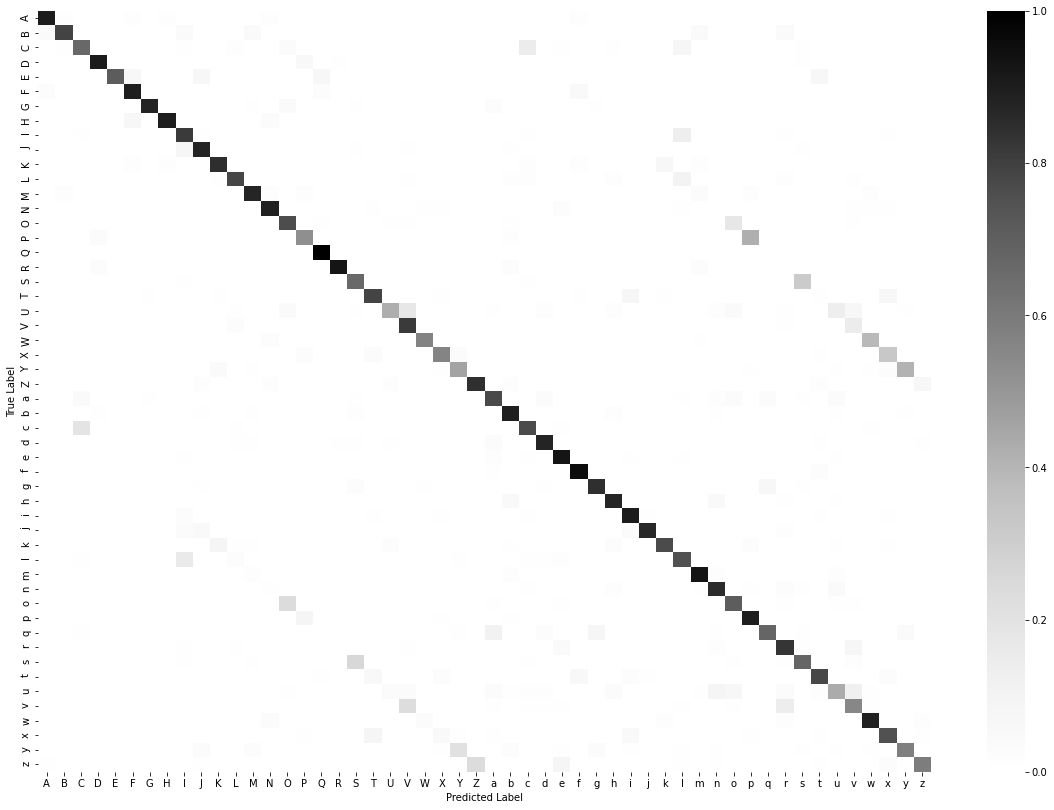

              precision    recall  f1-score   support

           A       0.94      0.90      0.92        52
           B       0.86      0.79      0.83        24
           C       0.74      0.67      0.70        93
           D       0.94      0.91      0.92        65
           E       1.00      0.71      0.83        14
           F       0.87      0.89      0.88        38
           G       0.97      0.88      0.92        67
           H       0.93      0.90      0.91        29
           I       0.70      0.81      0.75        96
           J       0.88      0.88      0.88       101
           K       0.81      0.85      0.83        60
           L       0.86      0.78      0.82        92
           M       0.83      0.87      0.85        55
           N       0.89      0.89      0.89        82
           O       0.67      0.76      0.71        80
           P       0.64      0.53      0.58        55
           Q       0.90      1.00      0.95        36
           R       0.95    

In [21]:
%%time

from sklearn.metrics import confusion_matrix
import seaborn as sn

from sklearn.metrics import classification_report

set_digits = sorted(list(set(ltest)))

test_cm = confusion_matrix(ltest, ptest, labels=list(set_digits), normalize='true')

df_cm = pd.DataFrame(test_cm, index=set_digits, columns=set_digits)
plt.figure(figsize = (20,14))
sn_plot = sn.heatmap(df_cm, cmap="Greys")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print(classification_report(ltest, ptest, zero_division=0))

In [22]:
def plot_keras_history(history, name='', acc='acc'):
    """Plots keras history."""
    import matplotlib.pyplot as plt

    training_acc = history.history[acc]
    validation_acc = history.history['val_' + acc]
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(training_acc))

    plt.ylim(0, 1)
    plt.plot(epochs, training_acc, 'tab:blue', label='Training acc')
    plt.plot(epochs, validation_acc, 'tab:orange', label='Validation acc')
    plt.title('Training and validation accuracy  ' + name)
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'tab:green', label='Training loss')
    plt.plot(epochs, val_loss, 'tab:red', label='Validation loss')
    plt.title('Training and validation loss  ' + name)
    plt.legend()
    plt.show()
    plt.close()
if 'history' in locals():
    plot_keras_history(history)

In [23]:
exit()